In [1]:
%load_ext autoreload
%autoreload 2

from ETL import *
from yahist import Hist1D

from yahist.fit import fit_hist
from yahist.utils import ignore_division_errors
import scipy
import os
import mplhep as hep
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import style
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
style.use('seaborn-white')

In [2]:


class three_vector:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.r     = np.sqrt(x**2+y**2)
        self.theta = np.arctan2(self.r, z)
        self.eta   = -np.log(np.tan(self.theta/2))
        self.phi   = np.arctan2(y, x)
        
    @classmethod
    def fromEtaPhi(cls, eta, phi, z):
        cls.eta = eta
        cls.phi = phi
        cls.z = z
        cls.theta = 2*np.arctan(np.exp(cls.eta*(-1)))
        cls.r = z*np.tan(cls.theta)
        cls.x = cls.r*np.cos(cls.phi)
        cls.y = cls.r*np.sin(cls.phi)
        
        return cls

def get_sign(n1):

    return n1/(np.sqrt(n1*n1))

def fill(layers):
    global disk_new
    for disk, side in layers:
        disk_new[disk][side].sort(key=lambda x:x[1], reverse=True)

        y_s = {}

        for i in disk_new[disk][side]:
            if i[1] in y_s:
                y_s[i[1]].append(i[0])
            else:
                y_s[i[1]] = [i[0]]
            
            y_s[i[1]].sort()


        new_sensors = []

        for y in y_s:
            x_s = y_s[y]
            for i in range(len(x_s)-1):
                if get_sign(x_s[i]) == get_sign(x_s[i+1]):
                    if x_s[i+1]-x_s[i] - 43.6 > 1:
                        n_sensors = int((x_s[i+1]-x_s[i]-43.6)/43.6)
                        s = 43.6
                        for j in range(n_sensors):
                            new_sensors.append((x_s[i]+s,y))
                            s += 43.6
                

        disk_new[disk][side] += new_sensors

z_ref = 2.99825
z = [
    2.99825,
    3.0055,
    3.02075,
    3.0285,
]

import random

eta_max = 2.950
eta_min = 1.659
eta_range = eta_max-eta_min

nEvents = int(1e5)

eta = np.random.rand(nEvents)*eta_range + eta_min
phi = np.random.rand(nEvents)*2*np.pi - np.pi

vec = three_vector.fromEtaPhi(eta, phi, np.ones(nEvents)*3000)

vec_list = []
for x,y in zip(vec.x, vec.y):
    vec_list.append(three_vector(x,y,3000))

delta_z = 20.5 # approximated distance between similar layers (e.g. front disk1 - front disk 2)
colors = ['red','blue','green','yellow','black','maroon','wheat']
plt.style.use(hep.style.CMS)  # or ATLAS/LHCb
bins_1 = "50,300,1200"
bins_2 ="40,-%s,%s"%(np.pi,np.pi)
bins_3 = "40,1.659,2.950"
bins_4 = "5,-0.5,4.5"

den1 = Hist1D([v.r for v in vec_list], bins=bins_1)
den2 = Hist1D([v.phi for v in vec_list], bins=bins_2)
den3 = Hist1D([v.eta for v in vec_list], bins=bins_3)

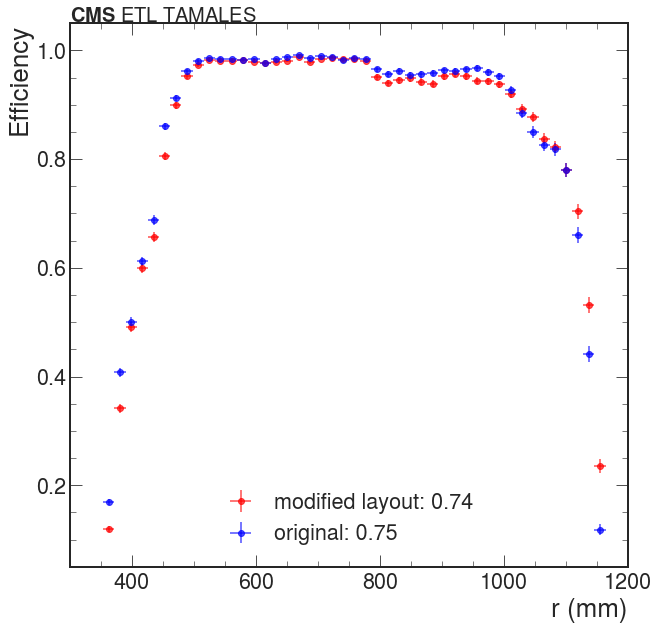

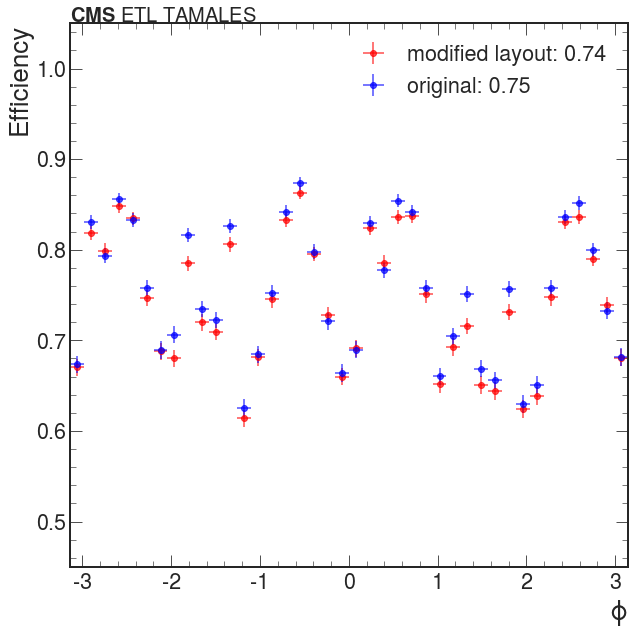

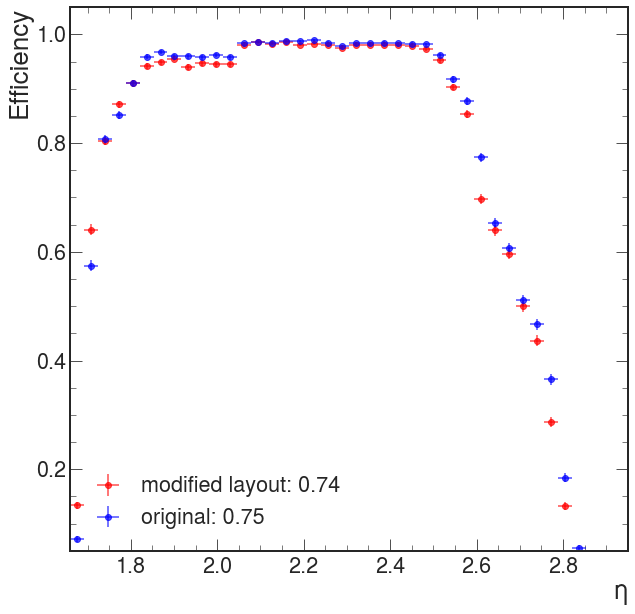

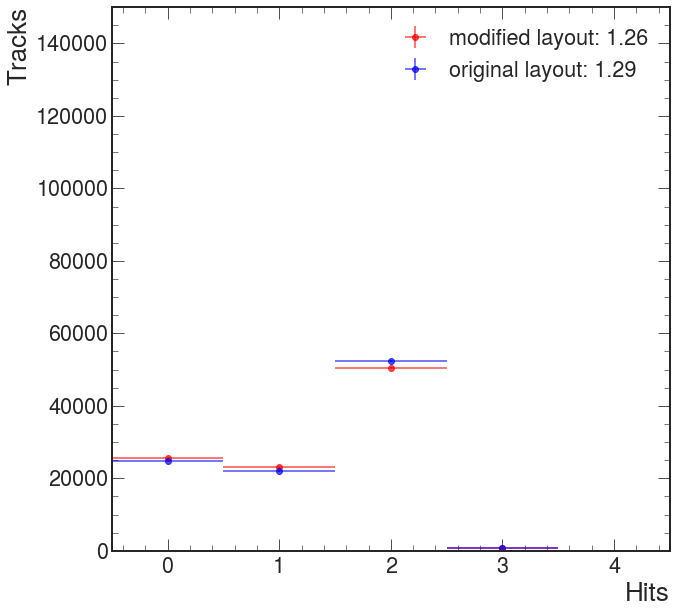

In [11]:
hists_1 = []
hists_2 = []
hists_3 = []
hists_4 = []
mean_nhits = []

m_pix = 16
n_pix = 16
gap = 0.05


with open('new_yamls_configs/database_new_config_6 filtered 800') as f:
    database_new = load(f, Loader=Loader)

disk_new = database_new['new'] 

layers = [['disk1','front'],['disk1','back'],['disk2','front'],['disk2','back']]

for i in range(2):

    if i == 1:
        with open('new_yamls_configs/database_new_original filtered 800') as f:
            database_new = load(f, Loader=Loader)

        disk_new = database_new['new']

    new_layout = {}

    s = Sensor2(21.4, 21.6)
    
    new_layout['D1'] = Dee(315, 1185)
    new_layout['D1'].fromCenters(disk_new['disk1']['front'], s)

    new_layout['D2'] = Dee(315, 1185)
    new_layout['D2'].fromCenters(disk_new['disk1']['back'], s)

    new_layout['D3'] = Dee(315, 1185)
    new_layout['D3'].fromCenters(disk_new['disk2']['front'], s)

    new_layout['D4'] = Dee(315, 1185)
    new_layout['D4'].fromCenters(disk_new['disk2']['back'], s)

    # new_layout['D1'] = Dee(315, 1185)
    # new_layout['D1'].fromCenters2(disk_new['disk1']['front'], s, m_pix, n_pix, gap)

    # new_layout['D2'] = Dee(315, 1185)
    # new_layout['D2'].fromCenters2(disk_new['disk1']['back'], s, m_pix, n_pix, gap)

    # new_layout['D3'] = Dee(315, 1185)
    # new_layout['D3'].fromCenters2(disk_new['disk2']['front'], s, m_pix, n_pix, gap)

    # new_layout['D4'] = Dee(315, 1185)
    # new_layout['D4'].fromCenters2(disk_new['disk2']['back'], s, m_pix, n_pix, gap)

    hits = {
        # 'TDR':[],
        # 'large_sensor':[],
        # #'large_sensor_v1':[], # with shift
        # 'small_sensor':[],
        # #'small_sensor_v1':[], # with shift
        # #'small_sensor_v2':[],
        # #'small_sensor_v3':[], # with shift
        'new_layout': [],
        }
    
    nHits = {
        # 'TDR':[],
        # 'large_sensor':[],
        # #'large_sensor_v1':[], # with shift
        # 'small_sensor':[],
        # #'small_sensor_v1':[], # with shift
        # #'small_sensor_v2':[],
        # #'small_sensor_v3':[], # with shift
        'new_layout': [],
    }

    detector_variants = {
        
        # 'large_sensor': large_sensor,
        # #'large_sensor_v1': large_sensor_v1,
        # 'small_sensor': small_sensor,
        # #'small_sensor_v1': small_sensor_v1,
        # #'small_sensor_v2': small_sensor_v2,
        # #'small_sensor_v3': small_sensor_v3,
        # 'TDR': TDR,
        'new_layout': new_layout,
            }



    # We also want to get the number of hits.
    for v in vec_list:
        
        
        
        for det in detector_variants:
            n = 0
            iLayer = 0

            for layer in ['D1','D2','D3','D4']:
                x_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.cos(v.phi)
                y_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.sin(v.phi)
                x,y = ((v.x + x_shift), (v.y + y_shift))
                    
                if detector_variants[det][layer].intersect(x, y):
                    n += 1
                iLayer += 1
                
            if n>0: hits[det].append(v)
            nHits[det].append(n)
    

    if i == 0:
        unfilled_eff = len(hits['new_layout'])/len(vec_list)
    else:
        filled_eff = len(hits['new_layout'])/len(vec_list)
    import os
    import mplhep as hep

    

    # num0 = Hist1D([v.eta for v in hits['TDR']], bins=bins)
    # num1 = Hist1D([v.eta for v in hits['large_sensor']], bins=bins)
    # num2 = Hist1D([v.eta for v in hits['small_sensor']], bins=bins)
    # #num3 = Hist1D([v.eta for v in hits['small_sensor_v2']], bins=bins)


    num1 = Hist1D([v.r for v in hits['new_layout']], bins=bins_1)
    num2 = Hist1D([v.phi for v in hits['new_layout']], bins=bins_2)
    num3 = Hist1D([v.eta for v in hits['new_layout']], bins=bins_3)
    
    #num4 = Hist1D([v.eta for v in hits['small_sensor_v3']], bins=bins)
    #num5 = Hist1D([v.eta for v in hits['small_sensor_v1']], bins=bins)
    #num6 = Hist1D([v.eta for v in hits['large_sensor_v1']], bins=bins)



    # h0 = num0.divide(den, binomial=True)
    h1 = num1.divide(den1, binomial=True)
    h2 = num2.divide(den2, binomial=True)
    h3 = num3.divide(den3, binomial=True)
    h4 = Hist1D(nHits['new_layout'], bins=bins_4)
    #h4 = num4.divide(den, binomial=True)
    #h5 = num5.divide(den, binomial=True)
    #h6 = num6.divide(den, binomial=True)
    hists_1.append(h1)
    hists_2.append(h2)
    hists_3.append(h3)
    hists_4.append(h4)

    # fig.savefig(os.path.join("{}.pdf".format(name)))
    # fig.savefig(os.path.join("{}.png".format(name)))

fig, ax = plt.subplots(1,1,figsize=(10,10))

for i in range(len(hists_1)):
    if i == 1:
        hists_1[i].plot(show_errors=True,color=colors[i],alpha=0.7,label='original: %.2f'%(filled_eff))

    else:
        hists_1[i].plot(show_errors=True,color=colors[i],label='modified layout: %.2f'%(unfilled_eff),alpha=0.7)

ax.set_ylabel('Efficiency')
ax.set_xlabel('r (mm)')

ax.set_ylim(0.05,1.05)

fig.text(0.0, 0.995, '$\\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

name = 'efficiency_vs_r_pixeled_6_filtered'
fig.savefig(os.path.join("{}.png".format(name)))

fig, ax = plt.subplots(1,1,figsize=(10,10))

for i in range(len(hists_2)):
    if i == 1:
        hists_2[i].plot(show_errors=True,color=colors[i],label='original: %.2f'%(filled_eff),alpha=0.7)

    else:
        hists_2[i].plot(show_errors=True,color=colors[i],label='modified layout: %.2f'%(unfilled_eff),alpha=0.7)


ax.set_ylim(0.45,1.05)

ax.set_ylabel('Efficiency')
ax.set_xlabel(r'$\phi$')

fig.text(0.0, 0.995, r'$\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

name = 'efficiency_vs_phi_pixeled_6_filtered'
fig.savefig(os.path.join("{}.png".format(name)))

fig, ax = plt.subplots(1,1,figsize=(10,10))

for i in range(len(hists_3)):
    if i == 1:
        hists_3[i].plot(show_errors=True,color=colors[i],label='original: %.2f'%(filled_eff),alpha=0.7)

    else:
        hists_3[i].plot(show_errors=True,color=colors[i],label='modified layout: %.2f'%(unfilled_eff),alpha=0.7)

ax.set_ylabel('Efficiency')
ax.set_xlabel(r'$\eta$')
ax.set_ylim(0.05,1.05)

name = 'efficiency_vs_eta_pixeled_6_filtered'

fig.savefig(os.path.join("{}.png".format(name)))

fig, ax = plt.subplots(1,1,figsize=(10,10))

for i in range(len(hists_4)):
    if i == 1:
        hists_4[i].plot(show_errors=True,histtype="step",color=colors[i],label='original layout: %.2f'%(hists_4[i].mean()),alpha=0.7)

    else:
        hists_4[i].plot(show_errors=True,histtype="step",color=colors[i],label='modified layout: %.2f'%(hists_4[i].mean()),alpha=0.7)

ax.set_ylabel('Tracks')
ax.set_xlabel('Hits')
ax.set_ylim(0,nEvents*1.5)
name = 'nHits_6_filtered'

fig.savefig(os.path.join("{}.png".format(name)))

In [11]:

for file in os.listdir('new_yamls_configs'):
    print(file)
#     with open(f'new_yamls_configs/{file}') as f:
#         database_new = load(f, Loader=Loader)
    
#     name = file.split('_')[-2] + ' ' + file.split('_')[-1]
#     disk_new = database_new['new'] 
#     print(name)
#     for layer in layers:
#         disk_number = layer[0]
#         face = layer[1]
#         modules_array = disk_new[disk_number][face]
#         print(len(modules_array))

database_new_config_1
database_new_config_2
database_new_config_3
database_new_config_4
database_new_config_5
database_new_config_6
database_new_original


36.82717665662782 database_new_config_1 filtered 800
36.96681513169343 database_new_config_2 filtered 800
36.64856130546569 database_new_config_3 filtered 800
36.944161164130705 database_new_config_4 filtered 800
37.26990070650337 database_new_config_5 filtered 800
36.74285314191158 database_new_config_6 filtered 800
36.500800510038864 database_new_original filtered 800


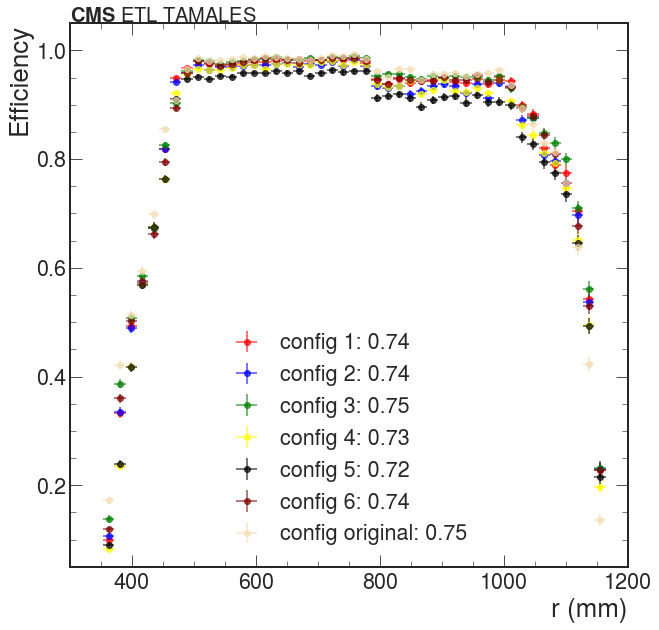

In [3]:
hists_1 = []
configs = range(0,7)
overall_efficiency = []

for file in os.listdir('new_yamls_configs'):
    if 'filtered' in file and 'ipynb' not in file:
        with open(f'new_yamls_configs/{file}') as f:
            database_new = load(f, Loader=Loader)

        disk_new = database_new['new'] 
        new_layout = {}

        if file == 'database_new.yaml':
            s = Sensor2(42.5, 22)
        else:
            s = Sensor2(21.4, 21.6)

        new_layout['D1'] = Dee(315, 1185)
        new_layout['D1'].fromCenters(disk_new['disk1']['front'], s)

        new_layout['D2'] = Dee(315, 1185)
        new_layout['D2'].fromCenters(disk_new['disk1']['back'], s)

        new_layout['D3'] = Dee(315, 1185)
        new_layout['D3'].fromCenters(disk_new['disk2']['front'], s)

        new_layout['D4'] = Dee(315, 1185)
        new_layout['D4'].fromCenters(disk_new['disk2']['back'], s)

        # new_layout['D1'] = Dee(315, 1185)
        # new_layout['D1'].fromCenters2(disk_new['disk1']['front'], s, m_pix, n_pix, gap)

        # new_layout['D2'] = Dee(315, 1185)
        # new_layout['D2'].fromCenters2(disk_new['disk1']['back'], s, m_pix, n_pix, gap)

        # new_layout['D3'] = Dee(315, 1185)
        # new_layout['D3'].fromCenters2(disk_new['disk2']['front'], s, m_pix, n_pix, gap)

        # new_layout['D4'] = Dee(315, 1185)
        # new_layout['D4'].fromCenters2(disk_new['disk2']['back'], s, m_pix, n_pix, gap)

        hits = {
            # 'TDR':[],
            # 'large_sensor':[],
            # #'large_sensor_v1':[], # with shift
            # 'small_sensor':[],
            # #'small_sensor_v1':[], # with shift
            # #'small_sensor_v2':[],
            # #'small_sensor_v3':[], # with shift
            'new_layout': [],
            }

        nHits = {
            # 'TDR':[],
            # 'large_sensor':[],
            # #'large_sensor_v1':[], # with shift
            # 'small_sensor':[],
            # #'small_sensor_v1':[], # with shift
            # #'small_sensor_v2':[],
            # #'small_sensor_v3':[], # with shift
            'new_layout': [],
        }

        detector_variants = {

            # 'large_sensor': large_sensor,
            # #'large_sensor_v1': large_sensor_v1,
            # 'small_sensor': small_sensor,
            # #'small_sensor_v1': small_sensor_v1,
            # #'small_sensor_v2': small_sensor_v2,
            # #'small_sensor_v3': small_sensor_v3,
            # 'TDR': TDR,
            'new_layout': new_layout,
                }



        # We also want to get the number of hits.
        for v in vec_list:



            for det in detector_variants:
                n = 0
                iLayer = 0

                for layer in ['D1','D2','D3','D4']:
                    x_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.cos(v.phi)
                    y_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.sin(v.phi)
                    x,y = ((v.x + x_shift), (v.y + y_shift))

                    if detector_variants[det][layer].intersect(x, y):
                        n += 1
                    iLayer += 1

                if n>0: hits[det].append(v)
                nHits[det].append(n)

        f0 = len(list(filter(lambda x:x==0,nHits['new_layout'])))/len(nHits['new_layout'])
        f1 = len(list(filter(lambda x:x==1,nHits['new_layout'])))/len(nHits['new_layout'])
        f2 = len(list(filter(lambda x:x==2,nHits['new_layout'])))/len(nHits['new_layout'])
        T = 46
        resolution = (f1*T + (f2*T)/np.sqrt(2))/(f1+f2)
        print(resolution,file)

        eff = len(hits['new_layout'])/len(vec_list)
        overall_efficiency.append(eff)
    #     if i == 0:
    #         unfilled_eff = len(hits['new_layout'])/len(vec_list)
    #     else:
    #         filled_eff = len(hits['new_layout'])/len(vec_list)
        import os
        import mplhep as hep



        # num0 = Hist1D([v.eta for v in hits['TDR']], bins=bins)
        # num1 = Hist1D([v.eta for v in hits['large_sensor']], bins=bins)
        # num2 = Hist1D([v.eta for v in hits['small_sensor']], bins=bins)
        # #num3 = Hist1D([v.eta for v in hits['small_sensor_v2']], bins=bins)


        num1 = Hist1D([v.r for v in hits['new_layout']], bins=bins_1)
    #     num2 = Hist1D([v.phi for v in hits['new_layout']], bins=bins_2)
    #     num3 = Hist1D([v.eta for v in hits['new_layout']], bins=bins_3)
        #num4 = Hist1D([v.eta for v in hits['small_sensor_v3']], bins=bins)
        #num5 = Hist1D([v.eta for v in hits['small_sensor_v1']], bins=bins)
        #num6 = Hist1D([v.eta for v in hits['large_sensor_v1']], bins=bins)



        # h0 = num0.divide(den, binomial=True)
        h1 = num1.divide(den1, binomial=True)
    #     h2 = num2.divide(den2, binomial=True)
    #     h3 = num3.divide(den3, binomial=True)
        #h4 = num4.divide(den, binomial=True)
        #h5 = num5.divide(den, binomial=True)
        #h6 = num6.divide(den, binomial=True)
        hists_1.append(h1)
    #     hists_2.append(h2)
    #     hists_3.append(h3)

fig, ax = plt.subplots(1,1,figsize=(10,10))

for i in range(len(hists_1)):
    if i != len(hists_1)-1:
        hists_1[i].plot(show_errors=True,color=colors[i],label=f'config {configs[i+1]}: %.2f'%(overall_efficiency[i]),alpha=0.7)
    else:
        hists_1[i].plot(show_errors=True,color=colors[i],label=f'config original: %.2f'%(overall_efficiency[i]),alpha=0.7)
ax.set_ylabel('Efficiency')
ax.set_xlabel('r (mm)')
ax.set_ylim(0.05,1.05)

fig.text(0.0, 0.995, '$\\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

fig.savefig('all_congifs_r_filtered')

In [9]:
os.listdir('new_yamls_configs')

['.ipynb_checkpoints',
 'database_new_config_1',
 'database_new_config_1 filtered 800',
 'database_new_config_2',
 'database_new_config_2 filtered 800',
 'database_new_config_3',
 'database_new_config_3 filtered 800',
 'database_new_config_4',
 'database_new_config_4 filtered 800',
 'database_new_config_5',
 'database_new_config_5 filtered 800',
 'database_new_config_6',
 'database_new_config_6 filtered 800',
 'database_new_original',
 'database_new_original filtered 800']

In [27]:
len(list(filter(lambda x:x==0,nHits['new_layout'])))/len(nHits['new_layout'])+len(list(filter(lambda x:x==1,nHits['new_layout'])))/len(nHits['new_layout'])+len(list(filter(lambda x:x==2,nHits['new_layout'])))/len(nHits['new_layout'])+len(list(filter(lambda x:x==3,nHits['new_layout'])))/len(nHits['new_layout'])+len(list(filter(lambda x:x==4,nHits['new_layout'])))/len(nHits['new_layout'])

1.0